# Advanced topics in recommender systems- EX1
---------

In [1]:
#!pip install scikit-optimize

## imports

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skopt
from skopt import gp_minimize
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence
np.random.seed(42)

## class of MF with bias

In [3]:
# creating new class for the Matrix Factorization
class MatrixFactorizationWithBiases:
    # the class get seed, hidden_dimension and option to print the metrics
    def __init__(self, seed, hidden_dimension, min_rating, max_rating, print_metrics=True):
        # define attricutes or seed with the inputs
        self.h_len = hidden_dimension
        np.random.seed(seed)
        self.print_metrics = print_metrics
        # initialize another attributes we need for MF
        self.results = {}
        self.user_map = None
        self.item_map = None
        self.global_bias = None
        self.user_biases = None
        self.item_biases = None
        self.x_u = None
        self.y_i = None
        self.lamda_bu = None
        self.lamda_bi = None
        self.lamda_xu = None
        self.lamda_yi = None
        self.epochs = None
        self.min_rating = min_rating
        self.max_rating = max_rating

    def get_results(self):
        return pd.DataFrame.from_dict(self.results)

    def record(self, epoch, **kwargs):
        # if we want to print metrices
        if self.print_metrics:
            print(f"\nepoch # {epoch} :")
        # for each parameter save the key
        for key, value in kwargs.items():
            key = f"{key}"
            # if key is not in the dictionary initialize it with empty list 
            if not self.results.get(key):
                self.results[key] = []
            # append the value
            self.results[key].append(value)
            # print if need
            if self.print_metrics:
                print(f"{key} : {np.round(value, 5)}")

    def set_params(self, **kwargs):
        # for each key and value set the value in the key attribute
        for key, value in kwargs.items():
            setattr(self, key, value)

    def fit(self, train, user_map, item_map, validation= None):
        pass
    
    
    def predict(self, user, item):
        # predict on user and item with their original ids not internal ids
        user = self.user_map.get(user, None)
        item = self.item_map.get(item, None)
        # if item or user doesn't exist in train return the global bias only 
        if user is None:
            if item is None:
                # return predict and check if it's not bigger than max_rating or lower than minimum
                return return_predict(self.global_bias,self.min_rating,self.max_rating) 
            # if just the user doesn't exist in train return the global bias with the item bias
            else:
                # return predict and check if it's not bigger than max_rating or lower than minimum
                return return_predict(self.global_bias+self.item_biases[item],self.min_rating,self.max_rating)
        # if just the item doesn't exist in train return the global bias with the user bias
        elif item is None:
            # return predict and check if it's not bigger than max_rating or lower than minimum
            return return_predict(self.global_bias +self.user_biases[user],self.min_rating,self.max_rating)
        # else return the predicting rating (regular calculating)
        else:
            # return predict and check if it's not bigger than max_rating or lower than minimum
            return return_predict(self.global_bias + self.user_biases[user] + self.item_biases[item] + np.inner(self.y_i[item],self.x_u[user]),self.min_rating,self.max_rating)


    def calc_loss(self, x):
        # initialize loss to 0
        loss = 0
        # create list of parameters 
        parameters = [self.user_biases, self.item_biases, self.x_u, self.y_i]
        # create list of parameters of regularization
        regularizations = [self.lamda_bu, self.lamda_bi, self.lamda_xu, self.lamda_yi]
        # compute the loss 
        for i in range(len(parameters)):
            loss += regularizations[i] * np.sum(np.square(parameters[i]))
        # return the total loss (regularization + prediction error)
        return loss + self.prediction_error(x, 'squared_error')
    
    
    def prediction_error(self, x, measure_function="rmse"):
        # dictionary for different measures
        error_functions = {'rmse': np.square, 'mae': np.abs, 'r2': np.square, 'squared_error': np.square}
        # get the function for error by the dictionary
        error_function = error_functions[measure_function]
        # initialize error
        e = 0
        t = 0
        # for each row in the data
        for row in x:
            # define the user, iten and rating
            user, item, rating = row
            # caculate the error by the choosen measure (reting minus prediction))
            e += error_function(rating - self.predict_on_pair(user, item))
            # if the measure is r2 append to t the error between the rating and global bias
            if measure_function == 'r2':
                t += error_function(rating - self.global_bias)
        # by the choosen measure return the error
        if measure_function == 'rmse':
            return np.sqrt(e / x.shape[0])
        elif measure_function == 'r2':
            return 1 - e / t
        elif measure_function == 'squared_error':
            return e
        else:
            return e / x.shape[0]

    def predict_on_pair(self, user, item):
        # if item or user doesn't exist in train return the global bias
        if user == -1:
            if item == -1:
                # return predict and check if it's not bigger than max_rating or lower than minimum
                return return_predict(self.global_bias,self.min_rating,self.max_rating)
             # if just the user doesn't exist in train return the global bias with the item bias
            elif item!= -1:
                # return predict and check if it's not bigger than max_rating or lower than minimum
                return return_predict(self.global_bias + self.item_biases[item],self.min_rating,self.max_rating)
        # if just the item doesn't exist in train return the global bias with the user bias
        elif item == -1:
            # return predict and check if it's not bigger than max_rating or lower than minimum
            return return_predict(self.global_bias + self.user_biases[user],self.min_rating,self.max_rating)
        # else return the predicting rating (regular calculating)
        else:
            # return predict and check if it's not bigger than max_rating or lower than minimum
            return return_predict(self.global_bias + self.user_biases[user] + self.item_biases[item] + np.inner(self.y_i[item],self.x_u[user]),self.min_rating,self.max_rating)

    def error_vs_epoch(self,epoch):
        # get the train and validation error
        train_error = self.results['train_error']
        validation_error = self.results['validation_error']
        # define list with all the epochs
        epochs = [i for i in range(1, epoch+1)]
        # plot train error and valisation error vs epochs
        plt.plot(epochs, train_error, label='Train Error')
        plt.plot(epochs, validation_error, label='Validation Error')
        # add xticks, legend and labels to x,y axis
        plt.xticks(np.arange(1, epoch+1, step=1))
        plt.legend(loc ='upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.show()

## class of config

In [4]:
# for creating the parameters for SGD or ALS
class Config:
    def __init__(self, **kwargs):
        self._set_attributes(kwargs)

    def _set_attributes(self, kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

    def add_attributes(self, **kwargs):
        self._set_attributes(kwargs)

## functions for running the models

In [5]:
def preprocess_for_mf(train, validation=None):
    # learn the indices of the train set
    # create dictionary with indeces and values of items
    dict_item = {k: v for v, k in enumerate(train[ITEM_COL].unique())}
    # create dictionary with indeces and values of users
    dict_user = {k: v for v, k in enumerate(train[USER_COL].unique())}
    # mapping from the old indices (for items and users) to the new ones
    train[ITEM_COL] = train[ITEM_COL].map(dict_item)
    train[USER_COL] = train[USER_COL].map(dict_user)
    
    # if we send validation set
    if validation is not None:
        # mapping from the old indices (for items and users) to the new ones for the validation set too
        validation[ITEM_COL] = validation[ITEM_COL].map(dict_item)
        validation[USER_COL] = validation[USER_COL].map(dict_user)
        # all the indexes that are not appear in the train set but indeed in the validation set to -1
        validation.fillna(-1, inplace=True)
        # change valudation to integers
        validation = validation.astype('int64')
        return train,validation,dict_user,dict_item
    return train, dict_user, dict_item


def get_mf(users_len, items_len, return_both=False):
    # dfeine the config for SGD and ALS (global varaibles)
    sgd_config = SGD_CONFIG
    als_config = ALS_CONFIG
    # add attributes of len of users and items for each config
    sgd_config.add_attributes(n_users=users_len, n_items=items_len)
    als_config.add_attributes(n_users=users_len, n_items=items_len)
    # if need to return both
    if return_both:
        # call to matrix factorization for both config
        return [MatrixFactorizationWithBiasesSGD(sgd_config),MatrixFactorizationWithBiasesALS(als_config)]
    # if SGD is True return MF only to SGD
    if SGD:
        return MatrixFactorizationWithBiasesSGD(sgd_config)
    # else: if ALS return only to ALS
    return MatrixFactorizationWithBiasesALS(als_config)


def train_on_all_predict_on_test(train, validation, test):
    # concat train and validation to 1 data set
    train_and_validation = pd.concat([train, validation], ignore_index=True)
    # appply the preprocess_for_mf function to get train, validation, dictionary for users and dictionary for items
    train_and_validation, user_map, item_map = preprocess_for_mf(train_and_validation)
    # define the len of the dictionaries (number of items and users)
    n_users, n_items = len(user_map), len(item_map)
    # apply the get_mf function and get the MF
    models = get_mf(n_users, n_items,True)
    # define list with the name of models
    model_names = ['sgd', 'als']
    # for each model
    for i, mf in enumerate(models):
        print ('################ the model now is', model_names[i], '################')
        # copy the test set
        temp_test = test.copy()
        # fit all the data
        mf.fit(train_and_validation, user_map, item_map)
        # get the prediction for te test set for each row (user and item)
        predictions = [mf.predict(int(row[USER_COL]), int(row[ITEM_COL])) for index, row in temp_test.iterrows()]
        # write the predictions in csv file
        temp_test["Rating"] = predictions
        if model_names[i] =='sgd':
            temp_test.to_csv('A_205948094_207331752_311244636.csv', index = False)
        else:
            temp_test.to_csv('B_205948094_207331752_311244636.csv', index = False)


def run_exp(model, train, user_map, item_map, validation):
    # if need to search the best parameters
    if HYPER_PARAM_SEARCH:
        # save current state after each iteration
        checkpoint_saver = CheckpointSaver(CHECKPOINT_NAME)
        # optimize the hyper paremters
        res_gp = gp_minimize(objective, space, n_calls=HYPER_PARAM_SEARCH_N_ITER, random_state=SEED, 
                             callback=[checkpoint_saver])
        # store an skopt optimization result into a file.
        skopt.dump(res_gp, HYPER_PARAM_FILE_NAME, store_objective=False)
        # plot the convergence
        plot_convergence(res_gp)
    # if do not need to search
    else:
        # fit the model
        model.fit(train, user_map, item_map, validation)
        # get valisation error in different measures
        validation_rmse = model.prediction_error(validation.values, 'rmse')
        validation_r2 = model.prediction_error(validation.values, 'r2')
        validation_mae = model.prediction_error(validation.values, 'mae')
        # print the results
        print ('\n################## result of measures ##################')
        print('validation_rmse:',validation_rmse,'validation_r2:',validation_r2,'validation_mae:',validation_mae)

# check if values is bigger then maximum or lower than minimum
def return_predict(value, min_rating, max_rating):
    # if the rating is lower than the minimum value return the minimum value
    if value < min_rating:
        return min_rating
    # if the rating is bigger than the maximum value return the maximum value
    elif value > max_rating:
        return max_rating
    # else return the value as is
    else:
        return value


----------
# SGD Classes

In [6]:
class SgdEarlyStopping:
    # get number of iterations for stop condition and minimum epoch
    def __init__(self, n_iter=3, min_epoch=6):
        # n_iter- if error is increasing for n_iter then stop
        # min_epoch- don't stop before min_epcoch
        # initializr parameters
        self.n_iter = n_iter
        self.last_value = 0
        self.last_last_value = 0
        self.consecutive_increasing_errors = 0
        self.min_epoch = min_epoch
    
    # def function for stop
    def stop(self, epoch, error):
        # check if epoch is bigger than the minimum epoch
        if epoch >= self.min_epoch:
            # if the error is bigger than the last value
            if error > self.last_value:
                # increase by 1 the number of times we had larger error
                self.consecutive_increasing_errors += 1
            # if the error is not bigger, set to zero
            else:
                self.consecutive_increasing_errors = 0
            # check if the error increase for 3 times at least and return True
            if self.consecutive_increasing_errors >= self.n_iter:
                return True
        # if not stop change the values of  last value and last last value
        self.last_last_value = self.last_value
        self.last_value = error
        return False


# create class for MF only for SGD that heiress from the class MatrixFactorizationWithBiases
class MatrixFactorizationWithBiasesSGD(MatrixFactorizationWithBiases):
    def __init__(self, config):
        # initialization parameters of the model
        super().__init__(config.seed, config.hidden_dimension, config.min_rating, config.max_rating, config.print_metrics)
        self.n_users = config.n_users
        self.n_items = config.n_items
        self.lr_xu= config.lr_xu
        self.lr_yi = config.lr_yi
        self.lr_bu = config.lr_bu
        self.lr_bi = config.lr_bi
        self.early_stopping = None
        self.lamda_xu = config.lamda_xu
        self.lamda_yi = config.lamda_yi
        self.lamda_bu = config.lamda_bu
        self.lamda_bi = config.lamda_bi
        self.epochs = config.epochs
        self.results = {}
        self.error = None

    # define fit function. 
    def fit(self, train, user_map, item_map, validation=None):
        # initialize the results
        self.results = {}
        # create object of early stopping
        self.early_stopping = SgdEarlyStopping()
        # define user map and item map
        self.user_map, self.item_map = user_map, item_map
        # initialize the biases of users and items to 0 array
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        # initialize x_u, y_i by random numbers from normal distribution
        self.x_u = np.random.normal(scale=0.2 / self.h_len, size=(self.n_users, self.h_len))
        self.y_i = np.random.normal(scale=0.2 / self.h_len, size=(self.n_items, self.h_len))
        # define the global bias by the mean
        self.global_bias = train[RATING_COL].mean()
        # return df as numpy array
        train = train.values
        # if we have validation return it also to numpy array
        if validation is not None:
            validation = validation.values
        # for each epoch 
        for epoch in range(1, self.epochs + 1):
            # shffuel the train 
            np.random.shuffle(train)
            # apply run_epoch with the train data (calculate error and updating parameters)
            self.run_epoch(train)
            # calculate error on the train data
            train_error = self.prediction_error(train, MEASURE)
            # caculate loss on the train data
            train_loss = self.calc_loss(train)
            # define dictionary for parameters of train error and loss
            convergence_params = {'train_error': train_error, 'train_loss': train_loss}
            # if we hhave validation
            if validation is not None:
                # calculate error on the validation data
                validation_error = self.prediction_error(validation, MEASURE)
                # caculate loss on the validation data
                validation_loss = self.calc_loss(validation)
                # set the error to validation error
                self.error = validation_error
                # append to the dictionary parameters of validation error and loss
                convergence_params.update({'validation_error': validation_error, 'validation_loss': validation_loss})
                # check if need to stop (by the current epoch and validation error)
                if self.early_stopping.stop(epoch, validation_error):
                    # update the results with the errors value
                    self.record(epoch, **convergence_params)
                    # update the error and break
                    self.error = self.early_stopping.last_last_value
                    break
            # update the results with the errors value
            self.record(epoch, **convergence_params)
        # if need to search parameters plot train and validation error vs epoch
        if HYPER_PARAM_SEARCH:
            self.error_vs_epoch(epoch)
        # return error
        return self.error

    def run_epoch(self, data):
        # for each row in tha data
        for row in data:
            # get the values in the row (user, item, rating)
            u, i, rui = row
            # predict rating by user and item
            prediction = self.predict_on_pair(u, i)
            # compute prediction error
            e_ui = rui - prediction
            # make a cupt of x_u with the current user
            xu = self.x_u[u,:].copy()
            # update all parameters
            self.user_biases[u] += self.lr_bu * (e_ui - self.lamda_bu * self.user_biases[u])
            self.item_biases[i] += self.lr_bi * (e_ui - self.lamda_bi * self.item_biases[i])
            self.x_u[u,:] += self.lr_xu * (e_ui * self.y_i[i,:] - self.lamda_yi * self.x_u[u,:])
            self.y_i[i,:] += self.lr_yi * (e_ui * xu - self.lamda_xu * self.y_i[i,:])


## ALS calsses

In [7]:
class AlsEarlyStopping:
    # get number of iterations for stop condition and minimum epoch
    def __init__(self, n_iter=3, min_epoch=6):
        # n_iter- if error is increasing for n_iter then stop
        # min_epoch- don't stop before min_epcoch
        # initializr parameters
        self.n_iter = n_iter
        self.last_value = 0
        self.last_last_value = 0
        self.consecutive_increasing_errors = 0
        self.min_epoch = min_epoch
    
    # def function for stop
    def stop(self, epoch, error):
        # check if epoch is bigger than the minimum epoch
        if epoch >= self.min_epoch:
             # if the error is bigger than the last value
            if error > self.last_value:
                # increase by 1 the number of times we had larger error
                self.consecutive_increasing_errors += 1
            # if the error is not bigger, set to zero
            else:
                self.consecutive_increasing_errors = 0
            # check if the error increase for 3 times at least and return True
            if self.consecutive_increasing_errors >= self.n_iter:
                return True
        # if not stop change the values of  last value and last last value
        self.last_last_value = self.last_value
        self.last_value = error
        return False

# create class for MF only for ALS that heiress from the class MatrixFactorizationWithBiases
class MatrixFactorizationWithBiasesALS(MatrixFactorizationWithBiases):
    def __init__(self, config):
        # initialization parameters of the model
        super().__init__(config.seed, config.hidden_dimension, config.min_rating, config.max_rating, config.print_metrics)
        self.n_users = config.n_users
        self.n_items = config.n_items
        self.lamda_xu = config.lamda_xu
        self.lamda_yi = config.lamda_yi
        self.lamda_bu = config.lamda_bu
        self.lamda_bi = config.lamda_bi
        self.epochs = config.epochs
        self.early_stopping = None
        self.user_dict = {}
        self.item_dict = {}
        self.results = {}
        self.error = None

    def dict_init(self, df):
        # for each user get all his ratings and their items
        for user in range(self.n_users):
            self.user_dict[user] = {'items': df[df[USER_COL] == user][ITEM_COL].values,
                                    'ratings': df[df[USER_COL] == user][RATING_COL].values}
        # for each item get all his ratings and their users
        for item in range(self.n_items): 
            self.item_dict[item] = {'users': df[df[ITEM_COL] == item][USER_COL].values,
                                    'ratings': df[df[ITEM_COL] == item][RATING_COL].values}

        
    def als_step(self):
        # for each user
        for u in range(self.n_users):
            # get vectors of items for the user
            item_vecs = self.y_i[self.user_dict[u]['items'], :]
            # get biases for user and item
            item_biases, user_bias = self.item_biases[self.user_dict[u]['items']], self.user_biases[u]
            # get all the ratings
            ratings = self.user_dict[u]['ratings']
            # number of ratings for this user
            n_items = ratings.size
            # define this phase for updating x_u
            a_ui = ratings - item_biases - user_bias - self.global_bias
            # calculate the left matrix in the cacluation for updating x_u
            user_left_matrix = np.linalg.inv(item_vecs.T.dot(item_vecs) + np.eye(self.h_len) * self.lamda_xu)
            # calculate the right matrix in the calculation for updating x_u
            user_right_vec = np.multiply(item_vecs.T, a_ui).sum(axis=1)
            # update the x_u parameter for the user
            self.x_u[u, :] = user_left_matrix.dot(user_right_vec)
            # calculate the right matrix in the cacluation for updating b_u
            user_bias_right_update = np.sum(ratings - item_biases - self.global_bias - item_vecs.dot(self.x_u[u, :]))
            # divide the result (as we need for this calculation for updating)
            user_bias_left_update = 1 / (self.lamda_bu + n_items)
            # update the b_u parameter for the user
            self.user_biases[u] = user_bias_left_update * user_bias_right_update  # update current user biases
        
        # for each item
        for i in range(self.n_items):
            # get vectors of users for the item
            user_vecs = self.x_u[self.item_dict[i]['users'], :]
            # get biases for user and item
            user_biases, item_bias = self.user_biases[self.item_dict[i]['users']], self.item_biases[i]
            # get all the ratings
            ratings = self.item_dict[i]['ratings']
            # number of ratings for this item
            n_users = ratings.size
            # define this phase
            a_ui = ratings - user_biases - item_bias - self.global_bias
            # calculate the left matrix in the cacluation for updating y_i
            item_left_matrix = np.linalg.inv(user_vecs.T.dot(user_vecs) + np.eye(self.h_len) * self.lamda_yi)
            # calculate the right matrix in the calculation for updating y_i
            item_right_vec = np.multiply(user_vecs.T, a_ui).sum(axis=1)
            # update the y_i parameter for the item
            self.y_i[i, :] = item_left_matrix.dot(item_right_vec)
            # calculate the right matrix in the cacluation for updating b_i
            item_bias_right_update = np.sum(ratings - user_biases - self.global_bias - user_vecs.dot(self.y_i[i, :]))
            # divide the result (as we need for this calculation for updating)
            item_bias_left_update = 1 / (self.lamda_bi + n_users)
            # update the b_i parameter for the item
            self.item_biases[i] = item_bias_left_update * item_bias_right_update
            
    # define fit function. 
    def fit(self, train, user_map: dict, item_map: dict, validation=None):
        # initialize the results
        self.results = {}
        # create object of early stopping
        self.early_stopping = AlsEarlyStopping()
        # surt train by users and then by items
        train = train.sort_values(by=[USER_COL, ITEM_COL])
        # if we have validation sort this data set too
        if validation is not None:
            validation = validation.sort_values(by=[USER_COL, ITEM_COL])
             # return df as numpy array
            validation = validation.values
        # create data fir users and item in dictionaries
        self.dict_init(train)
        # return df as numpy array
        train = train.values
        # define user map and item map
        self.user_map, self.item_map = user_map, item_map
        # initialize x_u, y_i by random numbers from normal distribution
        self.x_u = np.random.normal(scale=1. / self.h_len, size=(self.n_users, self.h_len))
        self.y_i = np.random.normal(scale=1. / self.h_len, size=(self.n_items, self.h_len))
        # initialize the biases of users and items to 0 array
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        # define the global bias by the mean
        self.global_bias = np.mean(train[:, 2])
        # initialize the validation error
        validation_error = None
        # for each epoch 
        for epoch in range(1, self.epochs + 1):
            # aply the als
            self.als_step()
            # calculate error on the train data
            train_error = self.prediction_error(train, MEASURE)
            # caculate loss on the train data
            train_loss = self.calc_loss(train)
            # define dictionary for parameters of train error and loss
            convergence_params = {'train_error': train_error, 'train_loss': train_loss}
            # if we hhave validation
            if validation is not None:
                # calculate error on the validation data
                validation_error = self.prediction_error(validation, MEASURE)
                # caculate loss on the validation data
                validation_loss = self.calc_loss(validation)
                # append to the dictionary parameters of validation error and loss
                convergence_params.update({'validation_error': validation_error, 'validation_loss': validation_loss})
                # check if need to stop (by the current epoch and validation error)
                if self.early_stopping.stop(epoch, validation_error):
                    # update the results with the errors value
                    self.record(epoch, **convergence_params)
                    # update the error and break
                    self.error = self.early_stopping.last_last_value
                    break
            # update the results with the errors value
            self.record(epoch, **convergence_params)
        # if need to search parameters plot train and validation error vs epoch
        if HYPER_PARAM_SEARCH:
            self.error_vs_epoch(epoch)
        # return error
        return validation_error

----------
## parameters for paths and files

In [8]:
# define the paths for the files
TRAIN_PATH = 'Train.csv'
VALIDATION_PATH = 'Validation.csv'
TEST_PATH = 'Test.csv'
# defiend the names of the columns in ths files
USER_COL = 'User_ID_Alias'
ITEM_COL = 'Movie_ID_Alias'
RATING_COL = 'Ratings_Rating'

## read all files

In [9]:
# read all the csv files
train, validation, test = pd.read_csv(TRAIN_PATH), pd.read_csv(VALIDATION_PATH), pd.read_csv(TEST_PATH)

In [10]:
# save the minimum and maximum ratings for truncate ratings
min_rate = train['Ratings_Rating'].min()
max_rate = train['Ratings_Rating'].max()

In [11]:
# appply the preprocess_for_mf function to get train, validation, dictionary for users and dictionary for items
train, validation, user_map, item_map = preprocess_for_mf(train, validation)

In [12]:
# define the len of the dictionaries (number of items and users)
n_users, n_items = len(user_map), len(item_map)

-------
## Implement SGD tuning

<b> define parameters for this running and for the tuning

In [13]:
# sgd or als
SGD = True
# HYPER_PARAM_SEARCH or manual config- set to TRUE to search the best parameters
HYPER_PARAM_SEARCH = True
# number of parameters, seed and the measure for error
HYPER_PARAM_SEARCH_N_ITER = 10
SEED = 42
MEASURE = 'rmse'
# define the name of the model by SGD varailble (True/False)
model_name = 'sgd' if SGD else 'als'
# define names for files we need
CHECKPOINT_NAME = f"./checkpoint_{model_name}.pkl"
HYPER_PARAM_FILE_NAME = f"HyperParamResult_{model_name}.pkl"

# hyper parameter tuning
SGD_SPACE = [skopt.space.Real(0.005, 0.03, name='lr_xu', prior='uniform'),
             skopt.space.Real(0.005, 0.03, name='lr_yi', prior='uniform'),
             skopt.space.Real(0.005, 0.03, name='lr_bu', prior='uniform'),
             skopt.space.Real(0.005, 0.03, name='lr_bi', prior='uniform'),
             skopt.space.Real(0.001, 0.012, name='lamda_xu', prior='uniform'),
             skopt.space.Real(0.001, 0.012, name='lamda_yi', prior='uniform'),
             skopt.space.Real(0.001, 0.012, name='lamda_bu', prior='uniform'),
             skopt.space.Real(0.001, 0.012, name='lamda_bi', prior='uniform'),
             skopt.space.Categorical([16, 18, 20, 24, 28, 32], name='h_len')]
space = SGD_SPACE if SGD else ALS_SPACE

SGD_CONFIG = Config(
    min_rating = min_rate,
    max_rating = max_rate,
    print_metrics=True,
    hidden_dimension=8,
    lr_xu=0.01,
    lr_yi=0.01,
    lr_bu=0.01,
    lr_bi=0.01,
    lamda_xu=0.001,
    lamda_yi=0.001,
    lamda_bu=0.001,
    lamda_bi=0.001,
    epochs=15,
    seed=SEED)


ALS_CONFIG = Config(
    min_rating = min_rate,
    max_rating = max_rate,
    print_metrics=True,
    hidden_dimension=8,
    lamda_xu=0.5,
    lamda_yi=0.5,
    lamda_bu=0.5,
    lamda_bi=0.5,
    epochs=20,
    seed=SEED)

@skopt.utils.use_named_args(space)
def objective(**params):
    mf.set_params(**params)
    print({i: np.round(v, 3) for i, v in mf.__dict__.items() if i in params.keys()})
    return mf.fit(train, user_map, item_map, validation)

<b> get MF for SGD

In [14]:
# apply the get_mf function and get the MF
mf = get_mf(n_users, n_items)

<b> "turn on" tuning and run all the model

{'h_len': 18, 'lamda_bu': 0.006, 'lamda_bi': 0.005, 'lamda_xu': 0.006, 'lamda_yi': 0.002, 'lr_xu': 0.025, 'lr_yi': 0.01, 'lr_bu': 0.024, 'lr_bi': 0.02}

epoch # 1 :
train_error : 0.90723
train_loss : 707353.19901
validation_error : 0.96124
validation_loss : 5587.88202

epoch # 2 :
train_error : 0.90332
train_loss : 701263.75041
validation_error : 0.95809
validation_loss : 5553.3969

epoch # 3 :
train_error : 0.89901
train_loss : 694582.22828
validation_error : 0.95813
validation_loss : 5555.01219

epoch # 4 :
train_error : 0.8841
train_loss : 671749.98057
validation_error : 0.95136
validation_loss : 5479.58466

epoch # 5 :
train_error : 0.86656
train_loss : 645359.59312
validation_error : 0.93886
validation_loss : 5340.40356

epoch # 6 :
train_error : 0.84459
train_loss : 613054.17607
validation_error : 0.93177
validation_loss : 5265.47437

epoch # 7 :
train_error : 0.82089
train_loss : 579136.36133
validation_error : 0.91979
validation_loss : 5138.21202

epoch # 8 :
train_error : 0.79

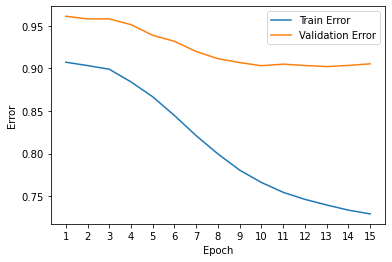

{'h_len': 16, 'lamda_bu': 0.008, 'lamda_bi': 0.008, 'lamda_xu': 0.001, 'lamda_yi': 0.012, 'lr_xu': 0.021, 'lr_yi': 0.006, 'lr_bu': 0.023, 'lr_bi': 0.028}

epoch # 1 :
train_error : 0.90763
train_loss : 707973.37557
validation_error : 0.95888
validation_loss : 5564.56811

epoch # 2 :
train_error : 0.90498
train_loss : 703847.82694
validation_error : 0.9612
validation_loss : 5594.02313

epoch # 3 :
train_error : 0.90369
train_loss : 701849.39933
validation_error : 0.9591
validation_loss : 5571.01697

epoch # 4 :
train_error : 0.90158
train_loss : 698574.15674
validation_error : 0.96077
validation_loss : 5591.22358

epoch # 5 :
train_error : 0.8925
train_loss : 684570.05999
validation_error : 0.95269
validation_loss : 5498.95349

epoch # 6 :
train_error : 0.87746
train_loss : 661697.80085
validation_error : 0.94722
validation_loss : 5438.22476

epoch # 7 :
train_error : 0.86115
train_loss : 637330.33467
validation_error : 0.93494
validation_loss : 5301.27718

epoch # 8 :
train_error : 0.8

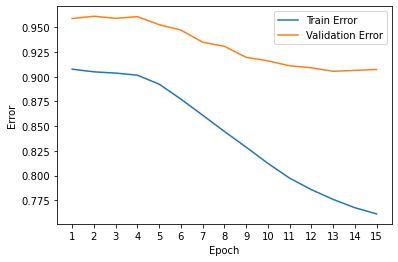

{'h_len': 20, 'lamda_bu': 0.002, 'lamda_bi': 0.008, 'lamda_xu': 0.012, 'lamda_yi': 0.004, 'lr_xu': 0.006, 'lr_yi': 0.018, 'lr_bu': 0.015, 'lr_bi': 0.006}

epoch # 1 :
train_error : 0.9162
train_loss : 721398.57798
validation_error : 0.97177
validation_loss : 5707.75718

epoch # 2 :
train_error : 0.90535
train_loss : 704411.65853
validation_error : 0.95913
validation_loss : 5562.17925

epoch # 3 :
train_error : 0.90185
train_loss : 698974.72298
validation_error : 0.9574
validation_loss : 5543.4159

epoch # 4 :
train_error : 0.8998
train_loss : 695800.82026
validation_error : 0.9565
validation_loss : 5533.79755

epoch # 5 :
train_error : 0.89687
train_loss : 691278.50536
validation_error : 0.956
validation_loss : 5528.8333

epoch # 6 :
train_error : 0.88917
train_loss : 679461.47673
validation_error : 0.95209
validation_loss : 5485.065

epoch # 7 :
train_error : 0.87794
train_loss : 662422.24642
validation_error : 0.94616
validation_loss : 5419.27297

epoch # 8 :
train_error : 0.86692
tr

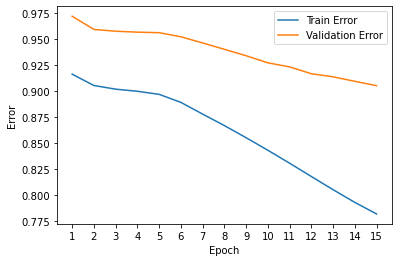

{'h_len': 20, 'lamda_bu': 0.011, 'lamda_bi': 0.007, 'lamda_xu': 0.006, 'lamda_yi': 0.001, 'lr_xu': 0.03, 'lr_yi': 0.017, 'lr_bu': 0.026, 'lr_bi': 0.022}

epoch # 1 :
train_error : 0.90784
train_loss : 708301.34485
validation_error : 0.96363
validation_loss : 5621.06013

epoch # 2 :
train_error : 0.90345
train_loss : 701468.47474
validation_error : 0.95989
validation_loss : 5580.88864

epoch # 3 :
train_error : 0.88506
train_loss : 673204.52219
validation_error : 0.95194
validation_loss : 5492.27414

epoch # 4 :
train_error : 0.85523
train_loss : 628603.47574
validation_error : 0.936
validation_loss : 5316.18436

epoch # 5 :
train_error : 0.82064
train_loss : 578790.95831
validation_error : 0.91762
validation_loss : 5118.72859

epoch # 6 :
train_error : 0.78916
train_loss : 535249.10472
validation_error : 0.90612
validation_loss : 5001.92794

epoch # 7 :
train_error : 0.7642
train_loss : 501940.86038
validation_error : 0.90131
validation_loss : 4959.74252

epoch # 8 :
train_error : 0.74

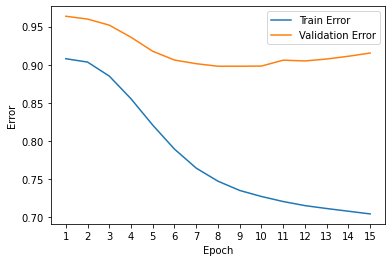

{'h_len': 18, 'lamda_bu': 0.003, 'lamda_bi': 0.005, 'lamda_xu': 0.008, 'lamda_yi': 0.01, 'lr_xu': 0.005, 'lr_yi': 0.011, 'lr_bu': 0.011, 'lr_bi': 0.022}

epoch # 1 :
train_error : 0.90908
train_loss : 710232.13068
validation_error : 0.96734
validation_loss : 5657.24912

epoch # 2 :
train_error : 0.90333
train_loss : 701283.99997
validation_error : 0.95951
validation_loss : 5567.66614

epoch # 3 :
train_error : 0.90167
train_loss : 698704.33462
validation_error : 0.95896
validation_loss : 5562.0447

epoch # 4 :
train_error : 0.90111
train_loss : 697835.45032
validation_error : 0.95809
validation_loss : 5552.57765

epoch # 5 :
train_error : 0.90062
train_loss : 697083.69822
validation_error : 0.9587
validation_loss : 5559.94083

epoch # 6 :
train_error : 0.89995
train_loss : 696036.84703
validation_error : 0.95949
validation_loss : 5569.48064

epoch # 7 :
train_error : 0.89729
train_loss : 691928.72248
validation_error : 0.95719
validation_loss : 5543.4796

epoch # 8 :
train_error : 0.89

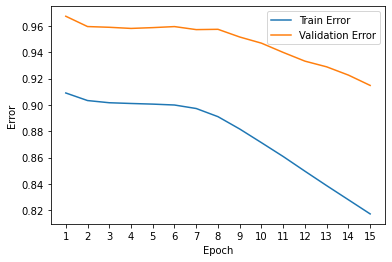

{'h_len': 32, 'lamda_bu': 0.006, 'lamda_bi': 0.005, 'lamda_xu': 0.001, 'lamda_yi': 0.01, 'lr_xu': 0.024, 'lr_yi': 0.016, 'lr_bu': 0.01, 'lr_bi': 0.019}

epoch # 1 :
train_error : 0.9098
train_loss : 711351.99344
validation_error : 0.96689
validation_loss : 5652.71423

epoch # 2 :
train_error : 0.90302
train_loss : 700802.60118
validation_error : 0.96234
validation_loss : 5601.72515

epoch # 3 :
train_error : 0.89672
train_loss : 691049.25779
validation_error : 0.9573
validation_loss : 5544.85445

epoch # 4 :
train_error : 0.87338
train_loss : 655551.14892
validation_error : 0.94184
validation_loss : 5371.05738

epoch # 5 :
train_error : 0.84447
train_loss : 612878.82395
validation_error : 0.92539
validation_loss : 5191.06339

epoch # 6 :
train_error : 0.81303
train_loss : 568106.13221
validation_error : 0.91086
validation_loss : 5037.46163

epoch # 7 :
train_error : 0.78092
train_loss : 524122.38369
validation_error : 0.90176
validation_loss : 4946.77668

epoch # 8 :
train_error : 0.75

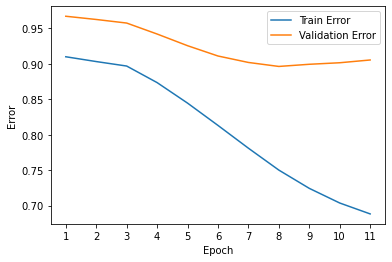

{'h_len': 24, 'lamda_bu': 0.009, 'lamda_bi': 0.007, 'lamda_xu': 0.012, 'lamda_yi': 0.01, 'lr_xu': 0.023, 'lr_yi': 0.013, 'lr_bu': 0.019, 'lr_bi': 0.018}

epoch # 1 :
train_error : 0.90741
train_loss : 707624.20934
validation_error : 0.96419
validation_loss : 5624.96463

epoch # 2 :
train_error : 0.90255
train_loss : 700073.35362
validation_error : 0.95909
validation_loss : 5568.71196

epoch # 3 :
train_error : 0.89913
train_loss : 694774.6052
validation_error : 0.95795
validation_loss : 5557.48175

epoch # 4 :
train_error : 0.88426
train_loss : 671999.28007
validation_error : 0.949
validation_loss : 5459.02072

epoch # 5 :
train_error : 0.86543
train_loss : 643684.32446
validation_error : 0.9379
validation_loss : 5340.23399

epoch # 6 :
train_error : 0.84084
train_loss : 607634.51892
validation_error : 0.92402
validation_loss : 5195.75465

epoch # 7 :
train_error : 0.8161
train_loss : 572428.8342
validation_error : 0.91321
validation_loss : 5090.36522

epoch # 8 :
train_error : 0.79344

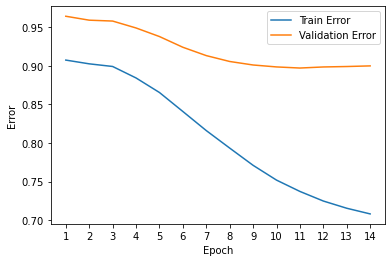

{'h_len': 18, 'lamda_bu': 0.006, 'lamda_bi': 0.005, 'lamda_xu': 0.003, 'lamda_yi': 0.001, 'lr_xu': 0.029, 'lr_yi': 0.02, 'lr_bu': 0.012, 'lr_bi': 0.012}

epoch # 1 :
train_error : 0.90986
train_loss : 711457.16901
validation_error : 0.96763
validation_loss : 5660.64487

epoch # 2 :
train_error : 0.90042
train_loss : 696770.3813
validation_error : 0.95744
validation_loss : 5544.41843

epoch # 3 :
train_error : 0.87071
train_loss : 651542.59208
validation_error : 0.9415
validation_loss : 5364.24556

epoch # 4 :
train_error : 0.83369
train_loss : 597331.69573
validation_error : 0.92071
validation_loss : 5134.40021

epoch # 5 :
train_error : 0.79949
train_loss : 549324.43769
validation_error : 0.90754
validation_loss : 4993.9318

epoch # 6 :
train_error : 0.77205
train_loss : 512281.19273
validation_error : 0.90056
validation_loss : 4922.76842

epoch # 7 :
train_error : 0.75376
train_loss : 488294.62175
validation_error : 0.8962
validation_loss : 4880.01097

epoch # 8 :
train_error : 0.741

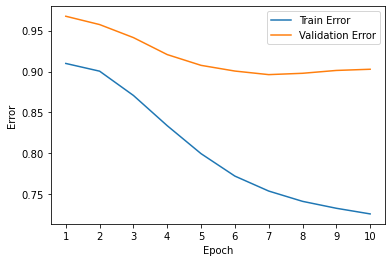

{'h_len': 28, 'lamda_bu': 0.008, 'lamda_bi': 0.011, 'lamda_xu': 0.008, 'lamda_yi': 0.011, 'lr_xu': 0.005, 'lr_yi': 0.01, 'lr_bu': 0.023, 'lr_bi': 0.025}

epoch # 1 :
train_error : 0.90788
train_loss : 708367.08812
validation_error : 0.96048
validation_loss : 5585.52483

epoch # 2 :
train_error : 0.90441
train_loss : 702961.97188
validation_error : 0.95911
validation_loss : 5573.01519

epoch # 3 :
train_error : 0.90327
train_loss : 701194.37886
validation_error : 0.96134
validation_loss : 5600.42906

epoch # 4 :
train_error : 0.90317
train_loss : 701049.26724
validation_error : 0.96478
validation_loss : 5641.4887

epoch # 5 :
train_error : 0.90325
train_loss : 701170.18826
validation_error : 0.9624
validation_loss : 5614.47434

epoch # 6 :
train_error : 0.9024
train_loss : 699852.61985
validation_error : 0.96143
validation_loss : 5603.48262

epoch # 7 :
train_error : 0.90079
train_loss : 697352.27783
validation_error : 0.96362
validation_loss : 5629.69501

epoch # 8 :
train_error : 0.89

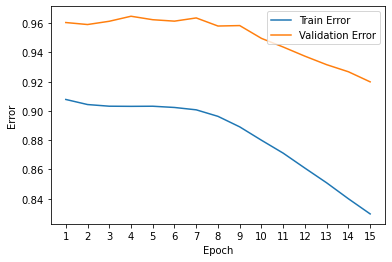

{'h_len': 20, 'lamda_bu': 0.004, 'lamda_bi': 0.007, 'lamda_xu': 0.008, 'lamda_yi': 0.008, 'lr_xu': 0.016, 'lr_yi': 0.007, 'lr_bu': 0.014, 'lr_bi': 0.022}

epoch # 1 :
train_error : 0.90832
train_loss : 709050.41952
validation_error : 0.96655
validation_loss : 5649.9892

epoch # 2 :
train_error : 0.90335
train_loss : 701317.08225
validation_error : 0.95888
validation_loss : 5562.88844

epoch # 3 :
train_error : 0.90166
train_loss : 698697.46917
validation_error : 0.9587
validation_loss : 5561.95121

epoch # 4 :
train_error : 0.90035
train_loss : 696663.5943
validation_error : 0.95778
validation_loss : 5552.0422

epoch # 5 :
train_error : 0.89487
train_loss : 688215.64412
validation_error : 0.9571
validation_loss : 5545.40647

epoch # 6 :
train_error : 0.88269
train_loss : 669606.91208
validation_error : 0.95011
validation_loss : 5467.63385

epoch # 7 :
train_error : 0.8692
train_loss : 649299.95593
validation_error : 0.94157
validation_loss : 5373.95054

epoch # 8 :
train_error : 0.8532

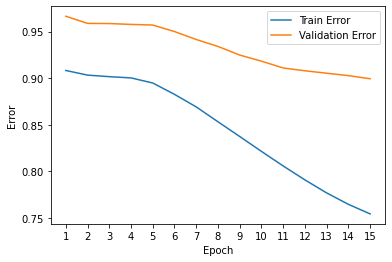

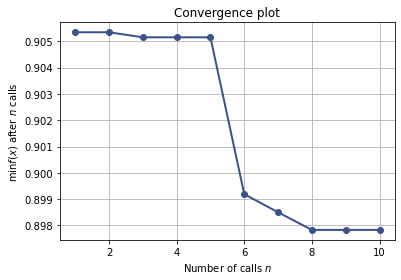

In [15]:
# run the SGD with all the train and calculation
run_exp(mf, train, user_map, item_map, validation)

<b> show the results of tuning

In [16]:
# load the pickl efile for the parameters from the tuning
res = skopt.load(r"checkpoint_sgd.pkl")
# conevrt the result to df
sgd_results = pd.DataFrame(res.x_iters, columns = ['lr_xu', 'lr_yi', 'lr_bu','lr_bi','lambda_xu','lambda_yi','lambda_bu','lambda_bi','hidden_dimension_size'])
# put the result column with the correct values
sgd_results['result'] = res.func_vals 
# sort the result by the score from the smallest to the largest
sgd_results = sgd_results.sort_values(by = 'result')
# display the results
sgd_results.style.bar(subset=['result'], align='mid', color=['#86BDEE'])

,lr_xu,lr_yi,lr_bu,lr_bi,lambda_xu,lambda_yi,lambda_bu,lambda_bi,hidden_dimension_size,result
7,0.029131,0.020176,0.011900,0.012407,0.002818,0.001172,0.005657,0.005344,18,0.897831
6,0.023182,0.013164,0.019261,0.018021,0.011573,0.010290,0.009221,0.006937,24,0.898502
5,0.023884,0.015629,0.010199,0.019193,0.001344,0.010265,0.005947,0.005347,32,0.899190
9,0.016236,0.007385,0.014270,0.021721,0.008325,0.007504,0.004022,0.007174,20,0.899424
2,0.005577,0.018119,0.014997,0.006167,0.011711,0.003560,0.001997,0.007802,20,0.905151
0,0.024914,0.009586,0.024492,0.019921,0.005904,0.002100,0.006052,0.004671,18,0.905343
1,0.021272,0.006410,0.023050,0.028464,0.001009,0.011914,0.007792,0.007728,16,0.907373
3,0.029581,0.016669,0.026499,0.022008,0.005955,0.001146,0.011364,0.007196,20,0.907473
4,0.005399,0.010772,0.011026,0.022082,0.007710,0.010165,0.002907,0.005302,18,0.914818
8,0.005352,0.009971,0.022784,0.024754,0.007666,0.011189,0.008162,0.011065,28,0.919921


<b> define the SGD config by the best parameters

In [17]:
SGD_CONFIG = Config(
    min_rating = min_rate,
    max_rating = max_rate,
    print_metrics=True,
    hidden_dimension=18,
    lr_xu=0.029131,
    lr_yi=0.020176,
    lr_bu=0.011900,
    lr_bi=0.012407,
    lamda_xu=0.002818,
    lamda_yi=0.001172,
    lamda_bu=0.005657,
    lamda_bi=0.005344,
    epochs=7,
    seed=SEED)

<b> caculate eMSE, MAe, R^2 on validation set

In [18]:
# read all the csv files
train, validation, test = pd.read_csv(TRAIN_PATH), pd.read_csv(VALIDATION_PATH), pd.read_csv(TEST_PATH)

In [19]:
# set the search to false
HYPER_PARAM_SEARCH = False
# apply all the model on the train and validation to calculate the measures on validation set with the best cinfiguration
train_2, validation_2, user_map, item_map = preprocess_for_mf(train.copy(), validation.copy())
n_users, n_items = len(user_map), len(item_map)
mf = get_mf(n_users, n_items)
run_exp(mf, train_2.copy(), user_map, item_map, validation_2.copy())


epoch # 1 :
train_error : 0.9099
train_loss : 711513.84105
validation_error : 0.96607
validation_loss : 5642.41946

epoch # 2 :
train_error : 0.89683
train_loss : 691227.87062
validation_error : 0.95548
validation_loss : 5521.8968

epoch # 3 :
train_error : 0.86926
train_loss : 649379.77723
validation_error : 0.93795
validation_loss : 5324.10446

epoch # 4 :
train_error : 0.83752
train_loss : 602828.64376
validation_error : 0.92376
validation_loss : 5168.24434

epoch # 5 :
train_error : 0.80336
train_loss : 554664.19731
validation_error : 0.9088
validation_loss : 5007.29766

epoch # 6 :
train_error : 0.77553
train_loss : 516900.85158
validation_error : 0.90356
validation_loss : 4954.97991

epoch # 7 :
train_error : 0.75618
train_loss : 491436.58999
validation_error : 0.90069
validation_loss : 4928.41771

################## result of measures ##################
validation_rmse: 0.9006937654174344 validation_r2: 0.3613694607732829 validation_mae: 0.6964657487040089


----------
## Implement ALS tuning

<b> define parameters for this running and for the tuning

In [20]:
# read all the csv files
train, validation, test = pd.read_csv(TRAIN_PATH), pd.read_csv(VALIDATION_PATH), pd.read_csv(TEST_PATH)

In [21]:
# sgd or als
SGD = False
# number of parameters, seed and the measure for error
HYPER_PARAM_SEARCH_N_ITER = 10
SEED = 42
MEASURE = 'rmse'
# define the name of the model by SGD varailble (True/False)
model_name = 'sgd' if SGD else 'als'
# define names for files we need
CHECKPOINT_NAME = f"./checkpoint_{model_name}.pkl"
HYPER_PARAM_FILE_NAME = f"HyperParamResult_{model_name}.pkl"

# hyper parameter tuning
ALS_SPACE = [skopt.space.Real(0.1, 0.9, name='lamda_xu', prior='uniform'),
             skopt.space.Real(0.1, 0.9, name='lamda_yi', prior='uniform'),
             skopt.space.Real(0.1, 0.9, name='lamda_bu', prior='uniform'),
             skopt.space.Real(0.1, 0.9, name='lamda_bi', prior='uniform'),
             skopt.space.Categorical([8, 16, 20, 24], name='h_len')]

space = SGD_SPACE if SGD else ALS_SPACE


ALS_CONFIG = Config(
    min_rating = min_rate,
    max_rating = max_rate,
    print_metrics=True,
    hidden_dimension=8,
    lamda_xu=0.5,
    lamda_yi=0.5,
    lamda_bu=0.5,
    lamda_bi=0.5,
    epochs=20,
    seed=SEED)


@skopt.utils.use_named_args(space)
def objective(**params):
    mf.set_params(**params)
    print({i: np.round(v, 3) for i, v in mf.__dict__.items() if i in params.keys()})
    return mf.fit(train, user_map, item_map, validation)

<b> get MF for ALS

In [22]:
# apply the get_mf function and get the MF
#mf = get_mf(n_users, n_items)

<b> "turn on" tuning and run all the model

{'h_len': 16, 'lamda_bu': 0.724, 'lamda_bi': 0.577, 'lamda_xu': 0.737, 'lamda_yi': 0.247}

epoch # 1 :
train_error : 0.86886
train_loss : 671080.29741
validation_error : 1.0133
validation_loss : 28512.04287

epoch # 2 :
train_error : 0.76509
train_loss : 526412.3507
validation_error : 0.97443
validation_loss : 29095.19225

epoch # 3 :
train_error : 0.73688
train_loss : 489160.48647
validation_error : 0.97355
validation_loss : 28246.33942

epoch # 4 :
train_error : 0.7234
train_loss : 471113.68011
validation_error : 0.97387
validation_loss : 27118.76622

epoch # 5 :
train_error : 0.71546
train_loss : 460332.49284
validation_error : 0.97316
validation_loss : 26143.53991

epoch # 6 :
train_error : 0.71029
train_loss : 453197.77923
validation_error : 0.97292
validation_loss : 25342.56473

epoch # 7 :
train_error : 0.70668
train_loss : 448148.17038
validation_error : 0.97419
validation_loss : 24698.0475

epoch # 8 :
train_error : 0.70401
train_loss : 444369.56174
validation_error : 0.97612


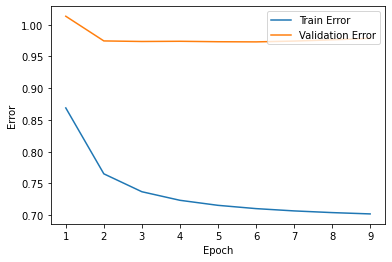

{'h_len': 20, 'lamda_bu': 0.367, 'lamda_bi': 0.214, 'lamda_xu': 0.18, 'lamda_yi': 0.467}

epoch # 1 :
train_error : 0.84594
train_loss : 643089.24042
validation_error : 1.06343
validation_loss : 34930.93235

epoch # 2 :
train_error : 0.74462
train_loss : 501109.06082
validation_error : 1.01525
validation_loss : 30832.73283

epoch # 3 :
train_error : 0.71328
train_loss : 460266.7995
validation_error : 1.00502
validation_loss : 29139.45403

epoch # 4 :
train_error : 0.69817
train_loss : 440456.88982
validation_error : 1.00403
validation_loss : 27638.96146

epoch # 5 :
train_error : 0.68927
train_loss : 428641.41001
validation_error : 1.00807
validation_loss : 26483.8607

epoch # 6 :
train_error : 0.6834
train_loss : 420741.78213
validation_error : 1.01276
validation_loss : 25566.47359

epoch # 7 :
train_error : 0.67922
train_loss : 415045.06186
validation_error : 1.01565
validation_loss : 24806.08098

epoch # 8 :
train_error : 0.67606
train_loss : 410710.07963
validation_error : 1.01806


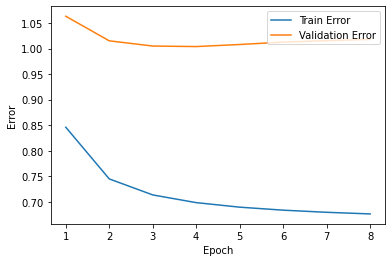

{'h_len': 24, 'lamda_bu': 0.851, 'lamda_bi': 0.101, 'lamda_xu': 0.145, 'lamda_yi': 0.678}

epoch # 1 :
train_error : 0.83054
train_loss : 627281.28705
validation_error : 1.06155
validation_loss : 41282.06305

epoch # 2 :
train_error : 0.72272
train_loss : 479307.93222
validation_error : 1.02254
validation_loss : 36734.26677

epoch # 3 :
train_error : 0.69022
train_loss : 437727.20347
validation_error : 1.0136
validation_loss : 34512.35622

epoch # 4 :
train_error : 0.67462
train_loss : 417441.85056
validation_error : 1.0133
validation_loss : 32522.81409

epoch # 5 :
train_error : 0.66535
train_loss : 405180.96462
validation_error : 1.01534
validation_loss : 30959.64142

epoch # 6 :
train_error : 0.65912
train_loss : 396831.82518
validation_error : 1.01847
validation_loss : 29737.13609

epoch # 7 :
train_error : 0.65462
train_loss : 390730.94366
validation_error : 1.02186
validation_loss : 28763.75702

epoch # 8 :
train_error : 0.6512
train_loss : 386065.61943
validation_error : 1.02596

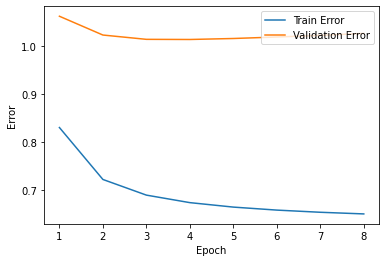

{'h_len': 20, 'lamda_bu': 0.106, 'lamda_bi': 0.118, 'lamda_xu': 0.594, 'lamda_yi': 0.589}

epoch # 1 :
train_error : 0.85403
train_loss : 653254.21784
validation_error : 1.02416
validation_loss : 32774.05579

epoch # 2 :
train_error : 0.74277
train_loss : 503571.04579
validation_error : 0.9836
validation_loss : 35279.20093

epoch # 3 :
train_error : 0.71236
train_loss : 464551.74836
validation_error : 0.98167
validation_loss : 34262.42005

epoch # 4 :
train_error : 0.69808
train_loss : 445841.64296
validation_error : 0.98737
validation_loss : 32932.1909

epoch # 5 :
train_error : 0.68969
train_loss : 434673.17126
validation_error : 0.99282
validation_loss : 31831.67712

epoch # 6 :
train_error : 0.68417
train_loss : 427225.82161
validation_error : 0.99642
validation_loss : 30946.83184

epoch # 7 :
train_error : 0.68026
train_loss : 421898.99622
validation_error : 0.99976
validation_loss : 30252.20452

epoch # 8 :
train_error : 0.67734
train_loss : 417912.22851
validation_error : 1.0024

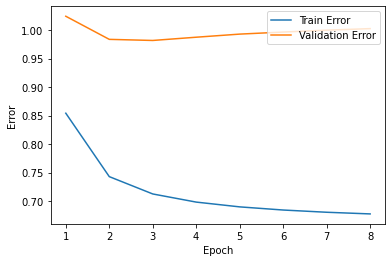

{'h_len': 8, 'lamda_bu': 0.879, 'lamda_bi': 0.286, 'lamda_xu': 0.42, 'lamda_yi': 0.137}

epoch # 1 :
train_error : 0.89797
train_loss : 704711.91274
validation_error : 1.04901
validation_loss : 18391.87006

epoch # 2 :
train_error : 0.81947
train_loss : 587065.66511
validation_error : 0.99204
validation_loss : 15906.28416

epoch # 3 :
train_error : 0.7947
train_loss : 552332.30188
validation_error : 0.97717
validation_loss : 15344.67653

epoch # 4 :
train_error : 0.78248
train_loss : 535371.44436
validation_error : 0.96765
validation_loss : 14841.11461

epoch # 5 :
train_error : 0.77578
train_loss : 526080.7857
validation_error : 0.96116
validation_loss : 14447.22346

epoch # 6 :
train_error : 0.77157
train_loss : 520238.99233
validation_error : 0.95772
validation_loss : 14167.26232

epoch # 7 :
train_error : 0.7687
train_loss : 516248.02534
validation_error : 0.9547
validation_loss : 13942.03151

epoch # 8 :
train_error : 0.76669
train_loss : 513435.20628
validation_error : 0.95254
va

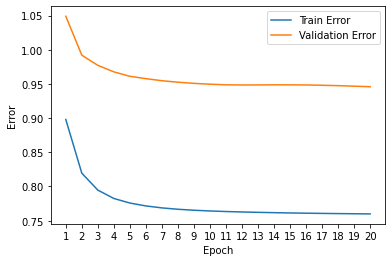

{'h_len': 24, 'lamda_bu': 0.887, 'lamda_bi': 0.473, 'lamda_xu': 0.595, 'lamda_yi': 0.406}

epoch # 1 :
train_error : 0.8334
train_loss : 626207.73268
validation_error : 1.02565
validation_loss : 35658.11881

epoch # 2 :
train_error : 0.72031
train_loss : 481155.82243
validation_error : 0.99214
validation_loss : 41206.4883

epoch # 3 :
train_error : 0.68958
train_loss : 442289.10705
validation_error : 0.99411
validation_loss : 39597.67955

epoch # 4 :
train_error : 0.67477
train_loss : 422840.99439
validation_error : 0.99903
validation_loss : 37580.01196

epoch # 5 :
train_error : 0.66577
train_loss : 410750.52837
validation_error : 1.00462
validation_loss : 35918.35565

epoch # 6 :
train_error : 0.65968
train_loss : 402418.39281
validation_error : 1.01008
validation_loss : 34591.4783

epoch # 7 :
train_error : 0.65527
train_loss : 396313.93727
validation_error : 1.01437
validation_loss : 33526.48932

epoch # 8 :
train_error : 0.65193
train_loss : 391667.3231
validation_error : 1.01805


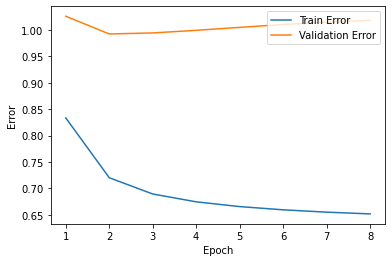

{'h_len': 20, 'lamda_bu': 0.111, 'lamda_bi': 0.854, 'lamda_xu': 0.644, 'lamda_yi': 0.46}

epoch # 1 :
train_error : 0.8528
train_loss : 650496.19497
validation_error : 1.03086
validation_loss : 31906.37404

epoch # 2 :
train_error : 0.7424
train_loss : 502529.1624
validation_error : 0.99399
validation_loss : 34839.20045

epoch # 3 :
train_error : 0.7132
train_loss : 465070.90899
validation_error : 0.99365
validation_loss : 33904.23647

epoch # 4 :
train_error : 0.6989
train_loss : 446299.57301
validation_error : 0.99556
validation_loss : 32510.47677

epoch # 5 :
train_error : 0.6902
train_loss : 434727.00589
validation_error : 0.99811
validation_loss : 31353.13614

epoch # 6 :
train_error : 0.68441
train_loss : 426948.63572
validation_error : 1.00015
validation_loss : 30431.97437

epoch # 7 :
train_error : 0.68033
train_loss : 421406.82304
validation_error : 1.00197
validation_loss : 29704.29413

epoch # 8 :
train_error : 0.6773
train_loss : 417272.05429
validation_error : 1.00424
vali

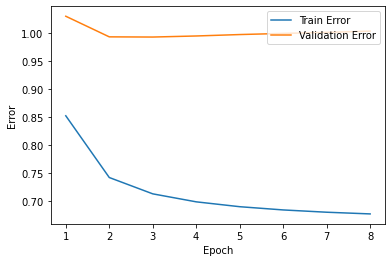

{'h_len': 20, 'lamda_bu': 0.285, 'lamda_bi': 0.293, 'lamda_xu': 0.408, 'lamda_yi': 0.113}

epoch # 1 :
train_error : 0.84643
train_loss : 642883.31253
validation_error : 1.03533
validation_loss : 33652.9002

epoch # 2 :
train_error : 0.74264
train_loss : 501655.57311
validation_error : 0.99966
validation_loss : 33726.51742

epoch # 3 :
train_error : 0.71423
train_loss : 464348.46981
validation_error : 0.99597
validation_loss : 31943.79991

epoch # 4 :
train_error : 0.70015
train_loss : 445238.74267
validation_error : 0.99545
validation_loss : 29938.7463

epoch # 5 :
train_error : 0.69145
train_loss : 433177.18312
validation_error : 0.99475
validation_loss : 28269.88018

epoch # 6 :
train_error : 0.68549
train_loss : 424748.00298
validation_error : 0.99583
validation_loss : 26910.18105

epoch # 7 :
train_error : 0.68113
train_loss : 418481.21706
validation_error : 0.99951
validation_loss : 25806.94616

epoch # 8 :
train_error : 0.67779
train_loss : 413615.43707
validation_error : 1.0045

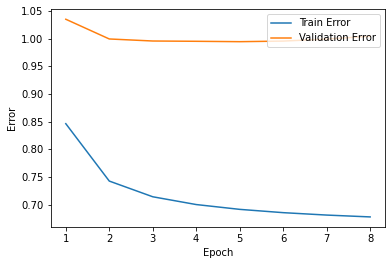

{'h_len': 16, 'lamda_bu': 0.239, 'lamda_bi': 0.413, 'lamda_xu': 0.588, 'lamda_yi': 0.767}

epoch # 1 :
train_error : 0.86792
train_loss : 671558.06695
validation_error : 1.03025
validation_loss : 30599.46028

epoch # 2 :
train_error : 0.7681
train_loss : 531592.14484
validation_error : 0.9774
validation_loss : 30337.83468

epoch # 3 :
train_error : 0.73938
train_loss : 493901.43937
validation_error : 0.96659
validation_loss : 29725.14598

epoch # 4 :
train_error : 0.72482
train_loss : 474714.73737
validation_error : 0.96328
validation_loss : 28828.97416

epoch # 5 :
train_error : 0.71614
train_loss : 463240.37474
validation_error : 0.96164
validation_loss : 28084.68555

epoch # 6 :
train_error : 0.71055
train_loss : 455799.55151
validation_error : 0.96129
validation_loss : 27490.85176

epoch # 7 :
train_error : 0.70675
train_loss : 450691.12187
validation_error : 0.96219
validation_loss : 27021.95927

epoch # 8 :
train_error : 0.70402
train_loss : 447003.87675
validation_error : 0.9633

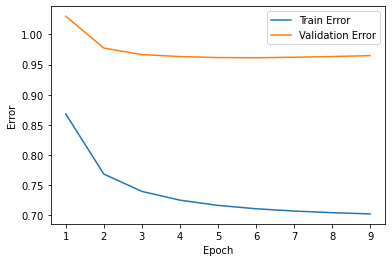

{'h_len': 8, 'lamda_bu': 0.266, 'lamda_bi': 0.554, 'lamda_xu': 0.704, 'lamda_yi': 0.44}

epoch # 1 :
train_error : 0.89313
train_loss : 698756.05244
validation_error : 1.02368
validation_loss : 19568.15745

epoch # 2 :
train_error : 0.81837
train_loss : 587860.9801
validation_error : 0.97621
validation_loss : 18048.57435

epoch # 3 :
train_error : 0.79327
train_loss : 553000.55027
validation_error : 0.96014
validation_loss : 17767.36131

epoch # 4 :
train_error : 0.78188
train_loss : 537353.68638
validation_error : 0.95165
validation_loss : 17444.42237

epoch # 5 :
train_error : 0.77569
train_loss : 528878.26262
validation_error : 0.94749
validation_loss : 17207.03113

epoch # 6 :
train_error : 0.7719
train_loss : 523679.89167
validation_error : 0.9444
validation_loss : 17012.27003

epoch # 7 :
train_error : 0.76934
train_loss : 520144.84463
validation_error : 0.94155
validation_loss : 16837.6451

epoch # 8 :
train_error : 0.76743
train_loss : 517494.79166
validation_error : 0.93907
va

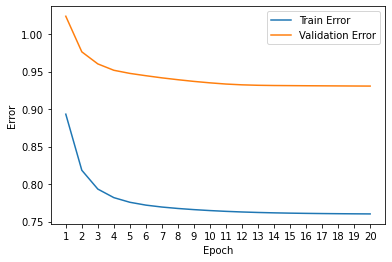

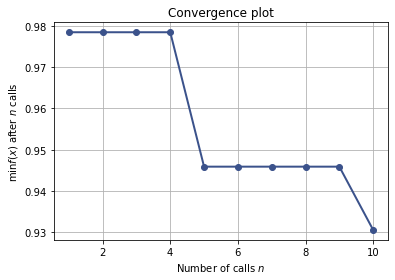

In [23]:
# set to TRUE to search the best parameters
HYPER_PARAM_SEARCH = True
train, validation, user_map, item_map = preprocess_for_mf(train, validation)
n_users, n_items = len(user_map), len(item_map)
# apply the get_mf function and get the MF
mf = get_mf(n_users, n_items)
# run the SGD with all the train and calculation
run_exp(mf, train, user_map, item_map, validation)

<b> show the results of tuning

In [24]:
# load the pickl efile for the parameters from the tuning
res = skopt.load(r"checkpoint_als.pkl")
# conevrt the result to df
sgd_results = pd.DataFrame(res.x_iters, columns = ['lambda_xu','lambda_yi','lambda_bu','lambda_bi','hidden_dimension_size'])
# put the result column with the correct values
sgd_results['result'] = res.func_vals 
# sort the result by the score from the smallest to the largest
sgd_results = sgd_results.sort_values(by = 'result')
# display the results
sgd_results.style.bar(subset=['result'], align='mid', color=['#86BDEE'])

,lambda_xu,lambda_yi,lambda_bu,lambda_bi,hidden_dimension_size,result
9,0.704289,0.440125,0.266353,0.554160,8,0.930582
4,0.419889,0.137333,0.879004,0.286217,8,0.945906
8,0.587997,0.766556,0.238692,0.412848,16,0.964833
0,0.737234,0.246748,0.723753,0.577480,16,0.978469
3,0.593985,0.589323,0.105653,0.118450,20,1.002440
6,0.644246,0.460399,0.110612,0.853761,20,1.004238
7,0.408333,0.112773,0.284715,0.292820,20,1.004516
5,0.594709,0.405970,0.886585,0.473410,24,1.018048
1,0.179980,0.467399,0.366967,0.214293,20,1.018057
2,0.145129,0.677599,0.850842,0.100623,24,1.025956


<b> define the ALS config by the best parameters

In [25]:
ALS_CONFIG = Config(
    min_rating = min_rate,
    max_rating = max_rate,
    print_metrics=True,
    hidden_dimension=8,
    lamda_xu=0.704289,
    lamda_yi=0.440125,
    lamda_bu=0.266353,
    lamda_bi=0.554160,
    epochs=18,
    seed=SEED)

<b> caculate eMSE, MAe, R^2 on validation set

In [26]:
# read all the csv files
train, validation, test = pd.read_csv(TRAIN_PATH), pd.read_csv(VALIDATION_PATH), pd.read_csv(TEST_PATH)

In [27]:
# set the search to false
HYPER_PARAM_SEARCH = False
# apply all the model on the train and validation to calculate the measures on validation set with the best cinfiguration
train, validation, user_map, item_map = preprocess_for_mf(train, validation)
n_users, n_items = len(user_map), len(item_map)
mf = get_mf(n_users, n_items)
run_exp(mf, train, user_map, item_map, validation)


epoch # 1 :
train_error : 0.8921
train_loss : 697304.49472
validation_error : 1.02742
validation_loss : 19732.95854

epoch # 2 :
train_error : 0.81884
train_loss : 588693.68905
validation_error : 0.97685
validation_loss : 18236.12706

epoch # 3 :
train_error : 0.79289
train_loss : 552690.4076
validation_error : 0.95525
validation_loss : 17917.23945

epoch # 4 :
train_error : 0.78093
train_loss : 536228.53962
validation_error : 0.94312
validation_loss : 17498.63096

epoch # 5 :
train_error : 0.77493
train_loss : 527971.3761
validation_error : 0.93695
validation_loss : 17197.0291

epoch # 6 :
train_error : 0.77133
train_loss : 523009.19804
validation_error : 0.93349
validation_loss : 16978.37207

epoch # 7 :
train_error : 0.76874
train_loss : 519427.29562
validation_error : 0.93109
validation_loss : 16798.03462

epoch # 8 :
train_error : 0.76665
train_loss : 516527.44865
validation_error : 0.92865
validation_loss : 16630.01677

epoch # 9 :
train_error : 0.76492
train_loss : 514121.00975

---------
# Run the final models
run with the best parameters we got from the tuning on both SGD and ALS

In [28]:
# read all the csv files
train, validation, test = pd.read_csv(TRAIN_PATH), pd.read_csv(VALIDATION_PATH), pd.read_csv(TEST_PATH)

In [29]:
# Final Run on all of the train data without search parameters
HYPER_PARAM_SEARCH = False
train_on_all_predict_on_test(train, validation, test)

################ the model now is sgd ################

epoch # 1 :
train_error : 0.91009
train_loss : 716817.95577

epoch # 2 :
train_error : 0.89667
train_loss : 695837.59339

epoch # 3 :
train_error : 0.8692
train_loss : 653847.16014

epoch # 4 :
train_error : 0.83647
train_loss : 605546.86065

epoch # 5 :
train_error : 0.80301
train_loss : 558069.38211

epoch # 6 :
train_error : 0.77506
train_loss : 519905.84929

epoch # 7 :
train_error : 0.75594
train_loss : 494583.52641
################ the model now is als ################

epoch # 1 :
train_error : 0.89786
train_loss : 711057.73073

epoch # 2 :
train_error : 0.82066
train_loss : 595206.14789

epoch # 3 :
train_error : 0.79751
train_loss : 562666.31721

epoch # 4 :
train_error : 0.78545
train_loss : 545877.45866

epoch # 5 :
train_error : 0.77765
train_loss : 535087.67352

epoch # 6 :
train_error : 0.77265
train_loss : 528188.8242

epoch # 7 :
train_error : 0.76936
train_loss : 523671.19273

epoch # 8 :
train_error : 0.76712
tra